In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3","/gpu:4"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-24 18:23:57.388129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:23:57.400299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:23:57.412768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:23:57.416536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:23:57.427043: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-10-24 18:23:59.850339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0
2024-10-24 18:23:59.852634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-24 18:23:59.854843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [5]:

import tensorflow as tf
import random

class ImageDataProcessor:
    def __init__(self, file_path, probability_threshold=0.5):
        self.file_path = file_path
        self.probability_threshold = probability_threshold
        self.images = None
        self.centers = None
        self.train_images = None
        self.val_images = None
        self.train_centers = None
        self.val_centers = None
        self.max_x = None
        self.max_y = None

    def load_data(self):
        # Load the data from the HDF5 file
        with h5py.File(self.file_path, 'r') as hdf5_file:
            self.images = hdf5_file['images'][:]
            self.centers = hdf5_file['centers_training'][:]
        return self.images, self.centers

    def normalize_data(self):
        # Normalize image data (0 to 1 range)
        self.images = self.images.astype(np.float32) / 255.0

        # Extract only the (x, y) coordinates
        x_coords = self.centers[:, :, 1]
        y_coords = self.centers[:, :, 2]
        
        # Get the maximum values for x and y coordinates
        self.max_x = np.max(x_coords)
        self.max_y = np.max(y_coords)
        
        # Normalize center coordinates (x, y) using max_x and max_y
        self.centers[:, :, 1] = x_coords / self.max_x  # Normalize x-coordinate
        self.centers[:, :, 2] = y_coords / self.max_y  # Normalize y-coordinate
        
        # Slice off the first column (probabilities) to keep only (x, y)
        self.centers = self.centers[:, :, 1:]

        # Add a new dimension so the shape is (n, 1, 5, 2)
        self.centers = np.expand_dims(self.centers, axis=1)

        print(f"Data normalized and centers reshaped to: {self.centers.shape}")
        return self.images, self.centers

    def split_data(self, test_size=0.2, random_state=42):
        # Split the data into training and validation sets
        self.train_images, self.val_images, self.train_centers, self.val_centers = train_test_split(
            self.images, self.centers, test_size=test_size, random_state=random_state
        )
        return self.train_images, self.val_images, self.train_centers, self.val_centers
    
    def prepare_tf_datasets(self, batch_size=1000, buffer_size=8000):
        # Create TensorFlow datasets from the training and validation data
        train_dataset = tf.data.Dataset.from_tensor_slices((self.train_images, self.train_centers))
        val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_centers))
        
        # Shuffle and batch the datasets
        train_dataset = train_dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True).batch(batch_size)
        val_dataset = val_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
        
        return train_dataset, val_dataset
    
    def plot_transposed_images_with_midpoints(self, dataset, image_indices=[0, 1, 2, 3]):
        # Plot images from the dataset with their corresponding midpoints
        for images, midpoints in dataset.take(1):  # Take the first batch from the dataset
            fig, axes = plt.subplots(1, len(image_indices), figsize=(16, 4))
            
            for i, ax in enumerate(axes):
                idx = image_indices[i]
                img = images[idx].numpy()
                midpoints_for_image = midpoints[idx].numpy()
                
                ax.imshow(img, cmap='gray')
                
                # Plot all midpoints for the image, rescale using max_x and max_y
                for midpoint in midpoints_for_image[0]:  # Access the added dimension
                    x = midpoint[0] * self.max_x  # Rescale x-coordinate
                    y = midpoint[1] * self.max_y  # Rescale y-coordinate
                    ax.scatter(x, y, c='red', marker='x', label='Midpoint')
                
                ax.set_title(f'Image {i + 1}')
                ax.axis('on')

            plt.tight_layout()
            plt.show()

In [6]:

# Create an instance of the class and test it with the provided data
processor = ImageDataProcessor(file_path='/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_5_32by32_95indexNoNoise.h5')


In [7]:


images, centers = processor.load_data()
normalized_images, normalized_centers = processor.normalize_data()
train_images, val_images, train_centers, val_centers = processor.split_data()

# Prepare TensorFlow datasets
train_dataset, val_dataset = processor.prepare_tf_datasets(batch_size=1000)


Data normalized and centers reshaped to: (30000, 1, 5, 2)


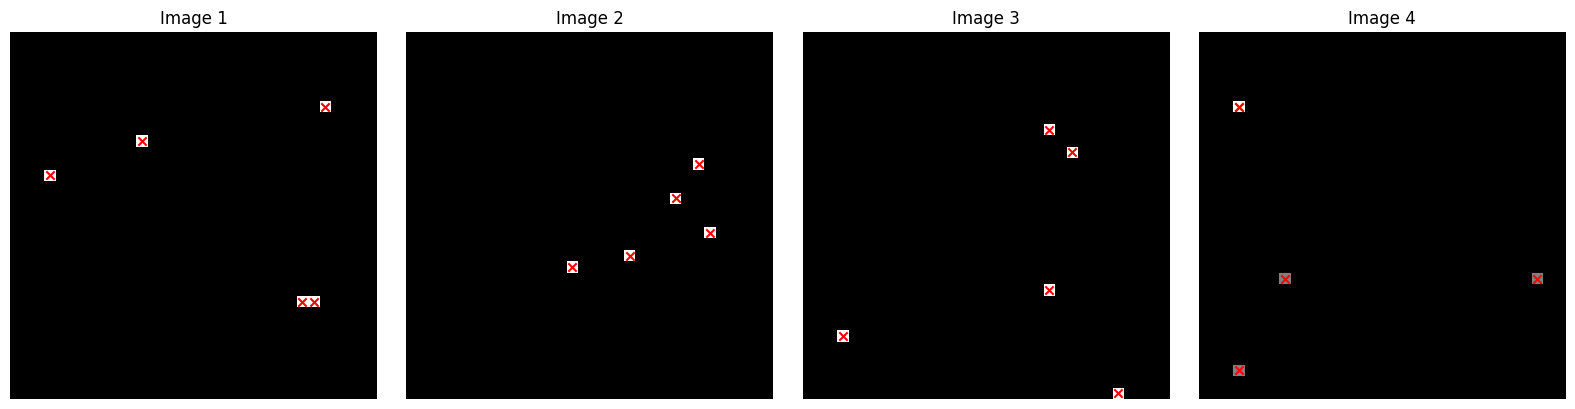

2024-10-24 18:25:52.961074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

# Plot transposed images with midpoints
processor.plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])


my NEW model

In [9]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-4, weights_path=None, l1_reg=0.001, l2_reg=0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
        
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [10]:
train_centers.shape

(24000, 1, 5, 2)

In [11]:
np.min(train_images), np.max(train_images), np.min(train_centers), np.max(train_centers)

(0.0, 0.69803923, 0.032258064, 1.0)

In [12]:
np.max(centers)

1.0

In [13]:
centers

array([[[1.        , 0.67741936, 0.7419355 ],
        [1.        , 0.7419355 , 0.83870965],
        [1.        , 0.22580644, 0.19354838],
        [1.        , 0.3548387 , 0.9354839 ],
        [1.        , 0.3548387 , 0.9032258 ]],

       [[1.        , 0.22580644, 0.32258064],
        [1.        , 0.5483871 , 0.7096774 ],
        [1.        , 0.9032258 , 0.19354838],
        [1.        , 0.09677419, 0.22580644],
        [1.        , 0.83870965, 0.4516129 ]],

       [[1.        , 0.6451613 , 0.38709676],
        [1.        , 0.87096775, 0.16129032],
        [1.        , 0.32258064, 1.        ],
        [1.        , 0.32258064, 0.32258064],
        [1.        , 0.8064516 , 0.516129  ]],

       ...,

       [[1.        , 0.9032258 , 0.9354839 ],
        [1.        , 0.4516129 , 0.29032257],
        [1.        , 0.2580645 , 0.19354838],
        [1.        , 0.83870965, 0.58064514],
        [1.        , 0.09677419, 0.48387095]],

       [[1.        , 0.48387095, 0.2580645 ],
        [1.  

In [14]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=5e-6
)


In [15]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,235,210 (31.41 MB)

 Trainable params: 8,234,698 (31.41 MB)

 Non-trainable params: 512 (2.00 KB)

In [16]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=600,
    callbacks_list=[lr_scheduler]
)


Epoch 1/600


2024-10-24 18:26:40.356753: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-24 18:26:48.557096: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-24 18:26:48.567336: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729794408.649602 1671859 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794408.652691 1671852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794408.691723 1671859 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794408.691885 1671852 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794408.692156 1671859 gpu_timer.cc:11

 2/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.3440 

W0000 00:00:1729794418.019114 1671848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.020746 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.021647 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.022648 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.023630 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.026129 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.027973 1671848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.028398 1671854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794418.030782 1671848 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1905

2024-10-24 18:26:59.723987: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-24 18:26:59.724382: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
W0000 00:00:1729794420.350223 1671849 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794420.350703 1671849 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794420.351120 1671849 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794420.351502 1671849 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729794420.351981 1671849 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be 

24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - loss: 0.1878 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 2/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0726 - val_loss: 0.3328 - learning_rate: 1.0000e-04
Epoch 3/600


2024-10-24 18:27:08.339096: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0695

2024-10-24 18:27:10.469234: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0695 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 4/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0685 - val_loss: 0.3223 - learning_rate: 1.0000e-04
Epoch 5/600


2024-10-24 18:27:13.620623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0676 - val_loss: 0.3188 - learning_rate: 1.0000e-04
Epoch 6/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0673 - val_loss: 0.3131 - learning_rate: 1.0000e-04
Epoch 7/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0674 - val_loss: 0.3059 - learning_rate: 1.0000e-04
Epoch 8/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0670 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 9/600


2024-10-24 18:27:24.069255: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0671 - val_loss: 0.2921 - learning_rate: 1.0000e-04
Epoch 10/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0668 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 11/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0668 - val_loss: 0.2791 - learning_rate: 1.0000e-04
Epoch 12/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0667 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 13/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0665 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 14/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0665 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 15/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0665

2024-10-24 18:27:41.708998: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0665 - val_loss: 0.2420 - learning_rate: 1.0000e-04
Epoch 16/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0664 - val_loss: 0.2296 - learning_rate: 1.0000e-04
Epoch 17/600


2024-10-24 18:27:44.792890: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0663 - val_loss: 0.2193 - learning_rate: 1.0000e-04
Epoch 18/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0661 - val_loss: 0.2081 - learning_rate: 1.0000e-04
Epoch 19/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0662 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 20/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0662 - val_loss: 0.1841 - learning_rate: 1.0000e-04
Epoch 21/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0663 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 22/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0660 - val_loss: 0.1539 - learning_rate: 1.0000e-04
Epoch 23/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0661 - val_loss: 0.1434 - learning_rate: 1.0000e-04
Epoch 24/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0655 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 25/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0658 - val_loss: 0.1166 - 

2024-10-24 18:28:12.849124: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0654 - val_loss: 0.1087 - learning_rate: 1.0000e-04
Epoch 28/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0656 - val_loss: 0.0930 - learning_rate: 1.0000e-04
Epoch 29/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0651 - val_loss: 0.0868 - learning_rate: 1.0000e-04
Epoch 30/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0652 - val_loss: 0.0815 - learning_rate: 1.0000e-04
Epoch 31/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0648 - val_loss: 0.0769 - learning_rate: 1.0000e-04
Epoch 32/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0650 - val_loss: 0.0790 - learning_rate: 1.0000e-04
Epoch 33/600


2024-10-24 18:28:26.415308: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0645 - val_loss: 0.0744 - learning_rate: 1.0000e-04
Epoch 34/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0645 - val_loss: 0.0743 - learning_rate: 1.0000e-04
Epoch 35/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0642 - val_loss: 0.0744 - learning_rate: 1.0000e-04
Epoch 36/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0641 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 37/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0636 - val_loss: 0.0730 - learning_rate: 1.0000e-04
Epoch 38/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0632 - val_loss: 0.0756 - learning_rate: 1.0000e-04
Epoch 39/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0631

2024-10-24 18:28:44.022140: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0631 - val_loss: 0.0729 - learning_rate: 1.0000e-04
Epoch 40/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0625 - val_loss: 0.0719 - learning_rate: 1.0000e-04
Epoch 41/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0620 - val_loss: 0.0780 - learning_rate: 1.0000e-04
Epoch 42/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0618 - val_loss: 0.0771 - learning_rate: 1.0000e-04
Epoch 43/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0610 - val_loss: 0.0771 - learning_rate: 1.0000e-04
Epoch 44/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0606 - val_loss: 0.0769 - learning_rate: 1.0000e-04
Epoch 45/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0596 - val_loss: 0.0764 - learning_rate: 1.0000e-04
Epoch 46/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0587 - val_loss: 0.0798 - learning_rate: 1.0000e-04
Epoch 47/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0581 - val_loss: 0.0811 - lear

2024-10-24 18:29:14.221704: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0537 - val_loss: 0.1019 - learning_rate: 9.0000e-05
Epoch 52/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0523 - val_loss: 0.0937 - learning_rate: 9.0000e-05
Epoch 53/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0510 - val_loss: 0.0995 - learning_rate: 9.0000e-05
Epoch 54/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0493 - val_loss: 0.0981 - learning_rate: 9.0000e-05
Epoch 55/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 0.0476 - val_loss: 0.0943 - learning_rate: 9.0000e-05
Epoch 56/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0465 - val_loss: 0.0875 - learning_rate: 9.0000e-05
Epoch 57/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0446 - val_loss: 0.0917 - learning_rate: 9.0000e-05
Epoch 58/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0426 - val_loss: 0.0976 - learning_rate: 9.0000e-05
Epoch 59/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0412 - val_loss: 0.0962 - 

2024-10-24 18:29:44.768009: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0351 - val_loss: 0.0986 - learning_rate: 8.1000e-05
Epoch 63/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0327 - val_loss: 0.1009 - learning_rate: 8.1000e-05
Epoch 64/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0312 - val_loss: 0.1041 - learning_rate: 8.1000e-05
Epoch 65/600


2024-10-24 18:29:50.719587: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0295 - val_loss: 0.1007 - learning_rate: 8.1000e-05
Epoch 66/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0280 - val_loss: 0.0970 - learning_rate: 8.1000e-05
Epoch 67/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0264 - val_loss: 0.0980 - learning_rate: 8.1000e-05
Epoch 68/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 0.0249 - val_loss: 0.1002 - learning_rate: 8.1000e-05
Epoch 69/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0234 - val_loss: 0.1049 - learning_rate: 8.1000e-05
Epoch 70/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0216
Epoch 70: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0216 - val_loss: 0.1044 - learning_rate: 8.1000e-05
Epoch 71/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0204 - val_loss: 0.1008 - learning_rate: 7.2900e-05
Epoch 72/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0186 - va

2024-10-24 18:30:14.933372: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0174 - val_loss: 0.1054 - learning_rate: 7.2900e-05
Epoch 74/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0163 - val_loss: 0.1030 - learning_rate: 7.2900e-05
Epoch 75/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0151 - val_loss: 0.1055 - learning_rate: 7.2900e-05
Epoch 76/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0142 - val_loss: 0.1064 - learning_rate: 7.2900e-05
Epoch 77/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0130 - val_loss: 0.1080 - learning_rate: 7.2900e-05
Epoch 78/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0123 - val_loss: 0.1005 - learning_rate: 7.2900e-05
Epoch 79/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0116 - val_loss: 0.1048 - learning_rate: 7.2900e-05
Epoch 80/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0108
Epoch 80: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0108 - val

2024-10-24 18:30:46.017005: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0072 - val_loss: 0.1058 - learning_rate: 6.5610e-05
Epoch 86/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0068 - val_loss: 0.1051 - learning_rate: 6.5610e-05
Epoch 87/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0063 - val_loss: 0.1025 - learning_rate: 6.5610e-05
Epoch 88/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0059 - val_loss: 0.1033 - learning_rate: 6.5610e-05
Epoch 89/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0055 - val_loss: 0.1036 - learning_rate: 6.5610e-05
Epoch 90/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0052
Epoch 90: ReduceLROnPlateau reducing learning rate to 5.904900172026828e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0052 - val_loss: 0.1034 - learning_rate: 6.5610e-05
Epoch 91/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0047 - val_loss: 0.1039 - learning_rate: 5.9049e-05
Epoch 92/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0043 - va

2024-10-24 18:31:17.730610: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0031 - val_loss: 0.1039 - learning_rate: 5.9049e-05
Epoch 98/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0029 - val_loss: 0.1039 - learning_rate: 5.9049e-05
Epoch 99/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0026 - val_loss: 0.1056 - learning_rate: 5.9049e-05
Epoch 100/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0026
Epoch 100: ReduceLROnPlateau reducing learning rate to 5.314410154824145e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0026 - val_loss: 0.1058 - learning_rate: 5.9049e-05
Epoch 101/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0024 - val_loss: 0.1048 - learning_rate: 5.3144e-05
Epoch 102/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0023 - val_loss: 0.1062 - learning_rate: 5.3144e-05
Epoch 103/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0021 - val_loss: 0.1062 - learning_rate: 5.3144e-05
Epoch 104/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.001

2024-10-24 18:31:48.815651: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0015 - val_loss: 0.1046 - learning_rate: 5.3144e-05
Epoch 110/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0014
Epoch 110: ReduceLROnPlateau reducing learning rate to 4.7829690083744934e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0014 - val_loss: 0.1038 - learning_rate: 5.3144e-05
Epoch 111/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0014 - val_loss: 0.1050 - learning_rate: 4.7830e-05
Epoch 112/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0012 - val_loss: 0.1048 - learning_rate: 4.7830e-05
Epoch 113/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0011 - val_loss: 0.1057 - learning_rate: 4.7830e-05
Epoch 114/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0011 - val_loss: 0.1047 - learning_rate: 4.7830e-05
Epoch 115/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0011 - val_loss: 0.1040 - learning_rate: 4.7830e-05
Epoch 116/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.

2024-10-24 18:32:19.205965: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 8.6294e-04 - val_loss: 0.1056 - learning_rate: 4.3047e-05
Epoch 122/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 8.2959e-04 - val_loss: 0.1045 - learning_rate: 4.3047e-05
Epoch 123/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 8.1759e-04 - val_loss: 0.1073 - learning_rate: 4.3047e-05
Epoch 124/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 7.6207e-04 - val_loss: 0.1035 - learning_rate: 4.3047e-05
Epoch 125/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 7.1557e-04 - val_loss: 0.1052 - learning_rate: 4.3047e-05
Epoch 126/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 6.9553e-04 - val_loss: 0.1057 - learning_rate: 4.3047e-05
Epoch 127/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 6.6039e-04 - val_loss: 0.1042 - learning_rate: 4.3047e-05
Epoch 128/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 6.3275e-04 - val_loss: 0.1050 - learning_rate: 4.3047e-05
Epoch 129/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/

2024-10-24 18:32:39.592713: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 6.3443e-04
Epoch 130: ReduceLROnPlateau reducing learning rate to 3.8742047036066654e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 6.3400e-04 - val_loss: 0.1047 - learning_rate: 4.3047e-05
Epoch 131/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 5.6067e-04 - val_loss: 0.1067 - learning_rate: 3.8742e-05
Epoch 132/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 5.8740e-04 - val_loss: 0.1052 - learning_rate: 3.8742e-05
Epoch 133/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.5567e-04

2024-10-24 18:32:49.576930: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 5.5416e-04 - val_loss: 0.1051 - learning_rate: 3.8742e-05
Epoch 134/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 5.7009e-04 - val_loss: 0.1050 - learning_rate: 3.8742e-05
Epoch 135/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 5.0925e-04 - val_loss: 0.1053 - learning_rate: 3.8742e-05
Epoch 136/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 4.8707e-04 - val_loss: 0.1058 - learning_rate: 3.8742e-05
Epoch 137/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 5.1931e-04 - val_loss: 0.1038 - learning_rate: 3.8742e-05
Epoch 138/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 4.9425e-04 - val_loss: 0.1050 - learning_rate: 3.8742e-05
Epoch 139/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 5.0815e-04 - val_loss: 0.1042 - learning_rate: 3.8742e-05
Epoch 140/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 5.2812e-04
Epoch 140: ReduceLROnPlateau reducing learning rate to 3.4867842987296176e-05.
24/24 ━━━━━━━━━━━━

2024-10-24 18:33:20.062647: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 4.2565e-04 - val_loss: 0.1050 - learning_rate: 3.4868e-05
Epoch 146/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 4.8683e-04 - val_loss: 0.1057 - learning_rate: 3.4868e-05
Epoch 147/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 4.3778e-04 - val_loss: 0.1047 - learning_rate: 3.4868e-05
Epoch 148/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 4.3384e-04 - val_loss: 0.1050 - learning_rate: 3.4868e-05
Epoch 149/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 4.7862e-04 - val_loss: 0.1057 - learning_rate: 3.4868e-05
Epoch 150/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 4.3337e-04
Epoch 150: ReduceLROnPlateau reducing learning rate to 3.138105967082083e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 4.3235e-04 - val_loss: 0.1054 - learning_rate: 3.4868e-05
Epoch 151/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 3.8979e-04 - val_loss: 0.1030 - learning_rate: 3.1381e-05
Epoch 152/600
24/24 ━━━━━━━━━━━━━

2024-10-24 18:33:50.521194: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 3.4361e-04 - val_loss: 0.1050 - learning_rate: 3.1381e-05
Epoch 158/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.4307e-04 - val_loss: 0.1046 - learning_rate: 3.1381e-05
Epoch 159/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 3.7700e-04 - val_loss: 0.1069 - learning_rate: 3.1381e-05
Epoch 160/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.3596e-04
Epoch 160: ReduceLROnPlateau reducing learning rate to 2.824295370373875e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 3.3487e-04 - val_loss: 0.1038 - learning_rate: 3.1381e-05
Epoch 161/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 3.3518e-04 - val_loss: 0.1054 - learning_rate: 2.8243e-05
Epoch 162/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 3.2943e-04 - val_loss: 0.1065 - learning_rate: 2.8243e-05
Epoch 163/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 3.2688e-04 - val_loss: 0.1037 - learning_rate: 2.8243e-05
Epoch 164/600
24/24 ━━━━━━━━━━━━━

2024-10-24 18:34:22.814885: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 3.3105e-04 - val_loss: 0.1045 - learning_rate: 2.8243e-05
Epoch 170/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3.3645e-04
Epoch 170: ReduceLROnPlateau reducing learning rate to 2.5418658333364876e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 3.3406e-04 - val_loss: 0.1068 - learning_rate: 2.8243e-05
Epoch 171/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 2.7823e-04 - val_loss: 0.1051 - learning_rate: 2.5419e-05
Epoch 172/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 2.5052e-04 - val_loss: 0.1049 - learning_rate: 2.5419e-05
Epoch 173/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 2.5932e-04 - val_loss: 0.1048 - learning_rate: 2.5419e-05
Epoch 174/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 2.5268e-04 - val_loss: 0.1053 - learning_rate: 2.5419e-05
Epoch 175/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 2.5458e-04 - val_loss: 0.1043 - learning_rate: 2.5419e-05
Epoch 176/600
24/24 ━━━━━━━━━━━━

2024-10-24 18:34:54.035109: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 2.6360e-04 - val_loss: 0.1056 - learning_rate: 2.2877e-05
Epoch 182/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.3733e-04 - val_loss: 0.1049 - learning_rate: 2.2877e-05
Epoch 183/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 2.9136e-04 - val_loss: 0.1052 - learning_rate: 2.2877e-05
Epoch 184/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 2.5423e-04 - val_loss: 0.1050 - learning_rate: 2.2877e-05
Epoch 185/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.7285e-04 - val_loss: 0.1046 - learning_rate: 2.2877e-05
Epoch 186/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 2.6085e-04 - val_loss: 0.1028 - learning_rate: 2.2877e-05
Epoch 187/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.3433e-04 - val_loss: 0.1046 - learning_rate: 2.2877e-05
Epoch 188/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 2.6778e-04 - val_loss: 0.1054 - learning_rate: 2.2877e-05
Epoch 189/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/st

2024-10-24 18:35:24.699038: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 2.6647e-04 - val_loss: 0.1047 - learning_rate: 2.0589e-05
Epoch 193/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.5949e-04 - val_loss: 0.1056 - learning_rate: 2.0589e-05
Epoch 194/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 2.3164e-04 - val_loss: 0.1057 - learning_rate: 2.0589e-05
Epoch 195/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.2798e-04 - val_loss: 0.1042 - learning_rate: 2.0589e-05
Epoch 196/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 2.2428e-04 - val_loss: 0.1046 - learning_rate: 2.0589e-05
Epoch 197/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 2.2928e-04 - val_loss: 0.1048 - learning_rate: 2.0589e-05
Epoch 198/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 2.1215e-04 - val_loss: 0.1054 - learning_rate: 2.0589e-05
Epoch 199/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.1855e-04 - val_loss: 0.1039 - learning_rate: 2.0589e-05
Epoch 200/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/s

2024-10-24 18:35:55.874542: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 2.1592e-04 - val_loss: 0.1045 - learning_rate: 1.8530e-05
Epoch 205/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.0215e-04 - val_loss: 0.1062 - learning_rate: 1.8530e-05
Epoch 206/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 1.9968e-04 - val_loss: 0.1049 - learning_rate: 1.8530e-05
Epoch 207/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.8937e-04 - val_loss: 0.1048 - learning_rate: 1.8530e-05
Epoch 208/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 1.9923e-04 - val_loss: 0.1039 - learning_rate: 1.8530e-05
Epoch 209/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.0801e-04 - val_loss: 0.1047 - learning_rate: 1.8530e-05
Epoch 210/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.0173e-04
Epoch 210: ReduceLROnPlateau reducing learning rate to 1.667718133830931e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 2.0155e-04 - val_loss: 0.1048 - learning_rate: 1.8530e-05
Epoch 211/600
24/24 ━━━━━━━━━━━━━

2024-10-24 18:36:27.038097: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 1.8138e-04 - val_loss: 0.1054 - learning_rate: 1.6677e-05
Epoch 217/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 2.1026e-04 - val_loss: 0.1041 - learning_rate: 1.6677e-05
Epoch 218/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 1.8660e-04 - val_loss: 0.1054 - learning_rate: 1.6677e-05
Epoch 219/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 2.0862e-04 - val_loss: 0.1047 - learning_rate: 1.6677e-05
Epoch 220/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 2.1889e-04
Epoch 220: ReduceLROnPlateau reducing learning rate to 1.5009462549642194e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 2.1842e-04 - val_loss: 0.1059 - learning_rate: 1.6677e-05
Epoch 221/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.9370e-04 - val_loss: 0.1047 - learning_rate: 1.5009e-05
Epoch 222/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 1.8145e-04 - val_loss: 0.1039 - learning_rate: 1.5009e-05
Epoch 223/600
24/24 ━━━━━━━━━━━━━━━

2024-10-24 18:36:57.904160: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.6549e-04 - val_loss: 0.1042 - learning_rate: 1.5009e-05
Epoch 229/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 1.7326e-04 - val_loss: 0.1052 - learning_rate: 1.5009e-05
Epoch 230/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.7897e-04
Epoch 230: ReduceLROnPlateau reducing learning rate to 1.3508516622096067e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 1.7784e-04 - val_loss: 0.1046 - learning_rate: 1.5009e-05
Epoch 231/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 1.6023e-04 - val_loss: 0.1056 - learning_rate: 1.3509e-05
Epoch 232/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.7414e-04 - val_loss: 0.1041 - learning_rate: 1.3509e-05
Epoch 233/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 1.8421e-04 - val_loss: 0.1049 - learning_rate: 1.3509e-05
Epoch 234/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.7327e-04 - val_loss: 0.1054 - learning_rate: 1.3509e-05
Epoch 235/600
24/24 ━━━━━━━━━━━━━━

2024-10-24 18:37:28.563483: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 240: ReduceLROnPlateau reducing learning rate to 1.2157664878031938e-05.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.5510e-04 - val_loss: 0.1054 - learning_rate: 1.3509e-05
Epoch 241/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 1.5667e-04 - val_loss: 0.1046 - learning_rate: 1.2158e-05
Epoch 242/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.4551e-04 - val_loss: 0.1048 - learning_rate: 1.2158e-05
Epoch 243/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.4863e-04 - val_loss: 0.1045 - learning_rate: 1.2158e-05
Epoch 244/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 1.4763e-04 - val_loss: 0.1055 - learning_rate: 1.2158e-05
Epoch 245/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.4788e-04 - val_loss: 0.1055 - learning_rate: 1.2158e-05
Epoch 246/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.7081e-04 - val_loss: 0.1034 - learning_rate: 1.2158e-05
Epoch 247/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.2468e-04 - val_loss: 0.1049 -

2024-10-24 18:37:58.991754: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3981e-04 - val_loss: 0.1053 - learning_rate: 1.0942e-05
Epoch 254/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3280e-04 - val_loss: 0.1046 - learning_rate: 1.0942e-05
Epoch 255/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1796e-04 - val_loss: 0.1064 - learning_rate: 1.0942e-05
Epoch 256/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.3567e-04 - val_loss: 0.1046 - learning_rate: 1.0942e-05
Epoch 257/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3473e-04 - val_loss: 0.1030 - learning_rate: 1.0942e-05
Epoch 258/600


2024-10-24 18:38:08.408880: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3724e-04 - val_loss: 0.1036 - learning_rate: 1.0942e-05
Epoch 259/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1789e-04 - val_loss: 0.1056 - learning_rate: 1.0942e-05
Epoch 260/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.3248e-04
Epoch 260: ReduceLROnPlateau reducing learning rate to 9.847708952293033e-06.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.3138e-04 - val_loss: 0.1031 - learning_rate: 1.0942e-05
Epoch 261/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1824e-04 - val_loss: 0.1046 - learning_rate: 9.8477e-06
Epoch 262/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2362e-04 - val_loss: 0.1037 - learning_rate: 9.8477e-06
Epoch 263/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2517e-04 - val_loss: 0.1078 - learning_rate: 9.8477e-06
Epoch 264/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2795e-04 - val_loss: 0.1059 - learning_rate: 9.8477e-06
Epoch 265/600
24/24 ━━━━━━━━━━━━━━━━━

2024-10-24 18:38:29.217746: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1080e-04 - val_loss: 0.1046 - learning_rate: 9.8477e-06
Epoch 268/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1097e-04 - val_loss: 0.1044 - learning_rate: 9.8477e-06
Epoch 269/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.1954e-04 - val_loss: 0.1055 - learning_rate: 9.8477e-06
Epoch 270/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.2082e-04
Epoch 270: ReduceLROnPlateau reducing learning rate to 8.862937647791114e-06.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.2008e-04 - val_loss: 0.1034 - learning_rate: 9.8477e-06
Epoch 271/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0492e-04 - val_loss: 0.1055 - learning_rate: 8.8629e-06
Epoch 272/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1071e-04 - val_loss: 0.1050 - learning_rate: 8.8629e-06
Epoch 273/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.1618e-04 - val_loss: 0.1049 - learning_rate: 8.8629e-06
Epoch 274/600
24/24 ━━━━━━━━━━━━━━━━━

2024-10-24 18:38:59.378049: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0525e-04
Epoch 280: ReduceLROnPlateau reducing learning rate to 7.976643883012003e-06.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0534e-04 - val_loss: 0.1043 - learning_rate: 8.8629e-06
Epoch 281/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1415e-04 - val_loss: 0.1050 - learning_rate: 7.9766e-06
Epoch 282/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1619e-04 - val_loss: 0.1044 - learning_rate: 7.9766e-06
Epoch 283/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.1149e-04 - val_loss: 0.1032 - learning_rate: 7.9766e-06
Epoch 284/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0180e-04 - val_loss: 0.1054 - learning_rate: 7.9766e-06
Epoch 285/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.3652e-05 - val_loss: 0.1038 - learning_rate: 7.9766e-06
Epoch 286/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 9.2338e-05 - val_loss: 0.1026 - learning_rate: 7.9766e-06
Epoch 287/600
24/24 ━━━━━━━━━━━━━━━━━

2024-10-24 18:39:31.071556: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1253e-04 - val_loss: 0.1041 - learning_rate: 7.1790e-06
Epoch 294/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.2196e-05 - val_loss: 0.1064 - learning_rate: 7.1790e-06
Epoch 295/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 9.9037e-05 - val_loss: 0.1047 - learning_rate: 7.1790e-06
Epoch 296/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 9.9529e-05 - val_loss: 0.1040 - learning_rate: 7.1790e-06
Epoch 297/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.1038e-04 - val_loss: 0.1046 - learning_rate: 7.1790e-06
Epoch 298/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.1317e-04 - val_loss: 0.1030 - learning_rate: 7.1790e-06
Epoch 299/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 9.4541e-05 - val_loss: 0.1042 - learning_rate: 7.1790e-06
Epoch 300/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 9.0553e-05
Epoch 300: ReduceLROnPlateau reducing learning rate to 6.461081602537889e-06.
24/24 ━━━━━━━━━━━━━━━━━

2024-10-24 18:40:01.372704: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0985e-04 - val_loss: 0.1032 - learning_rate: 6.4611e-06
Epoch 308/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.0589e-05 - val_loss: 0.1047 - learning_rate: 6.4611e-06
Epoch 309/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.0224e-04 - val_loss: 0.1064 - learning_rate: 6.4611e-06
Epoch 310/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 8.8538e-05
Epoch 310: ReduceLROnPlateau reducing learning rate to 5.814973565065884e-06.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.8807e-05 - val_loss: 0.1061 - learning_rate: 6.4611e-06
Epoch 311/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.9320e-05 - val_loss: 0.1037 - learning_rate: 5.8150e-06
Epoch 312/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 9.1526e-05 - val_loss: 0.1048 - learning_rate: 5.8150e-06
Epoch 313/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 8.1415e-05 - val_loss: 0.1039 - learning_rate: 5.8150e-06
Epoch 314/600
24/24 ━━━━━━━━━━━━━━━━━

2024-10-24 18:40:33.200518: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 320: ReduceLROnPlateau reducing learning rate to 5.233476167632034e-06.
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.1824e-05 - val_loss: 0.1033 - learning_rate: 5.8150e-06
Epoch 321/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.7677e-05 - val_loss: 0.1049 - learning_rate: 5.2335e-06
Epoch 322/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5325e-05 - val_loss: 0.1040 - learning_rate: 5.2335e-06
Epoch 323/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.1737e-05 - val_loss: 0.1074 - learning_rate: 5.2335e-06
Epoch 324/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.2766e-05 - val_loss: 0.1032 - learning_rate: 5.2335e-06
Epoch 325/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5513e-05 - val_loss: 0.1047 - learning_rate: 5.2335e-06
Epoch 326/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.7931e-05 - val_loss: 0.1055 - learning_rate: 5.2335e-06
Epoch 327/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.1841e-05 - val_loss: 0.1039 - l

2024-10-24 18:41:03.322299: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8660e-05 - val_loss: 0.1054 - learning_rate: 5.0000e-06
Epoch 335/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.5386e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 336/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.6921e-05 - val_loss: 0.1042 - learning_rate: 5.0000e-06
Epoch 337/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 7.5775e-05 - val_loss: 0.1035 - learning_rate: 5.0000e-06
Epoch 338/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.2833e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 339/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.0666e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 340/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.0234e-05 - val_loss: 0.1033 - learning_rate: 5.0000e-06
Epoch 341/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.9145e-05 - val_loss: 0.1042 - learning_rate: 5.0000e-06
Epoch 342/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step 

2024-10-24 18:41:33.467377: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.5062e-05 - val_loss: 0.1030 - learning_rate: 5.0000e-06
Epoch 347/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.2934e-05 - val_loss: 0.1027 - learning_rate: 5.0000e-06
Epoch 348/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.9563e-05 - val_loss: 0.1051 - learning_rate: 5.0000e-06
Epoch 349/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.9515e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 350/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.5248e-05 - val_loss: 0.1026 - learning_rate: 5.0000e-06
Epoch 351/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.9896e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 352/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.1395e-05 - val_loss: 0.1054 - learning_rate: 5.0000e-06
Epoch 353/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5755e-05 - val_loss: 0.1059 - learning_rate: 5.0000e-06
Epoch 354/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step 

2024-10-24 18:42:03.488335: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.2500e-05 - val_loss: 0.1022 - learning_rate: 5.0000e-06
Epoch 360/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3162e-05 - val_loss: 0.1056 - learning_rate: 5.0000e-06
Epoch 361/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.9151e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 362/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 9.1648e-05 - val_loss: 0.1045 - learning_rate: 5.0000e-06
Epoch 363/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3948e-05 - val_loss: 0.1042 - learning_rate: 5.0000e-06
Epoch 364/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.8304e-05 - val_loss: 0.1053 - learning_rate: 5.0000e-06
Epoch 365/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.0100e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 366/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.9122e-05 - val_loss: 0.1038 - learning_rate: 5.0000e-06
Epoch 367/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step 

2024-10-24 18:42:33.787558: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.6288e-05 - val_loss: 0.1056 - learning_rate: 5.0000e-06
Epoch 374/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.7890e-05 - val_loss: 0.1060 - learning_rate: 5.0000e-06
Epoch 375/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.1909e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 376/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 8.1573e-05 - val_loss: 0.1059 - learning_rate: 5.0000e-06
Epoch 377/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.3398e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 378/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.1204e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 379/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3766e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 380/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.9085e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 381/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step 

2024-10-24 18:43:03.923607: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.7643e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 387/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.0474e-05 - val_loss: 0.1025 - learning_rate: 5.0000e-06
Epoch 388/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.3269e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 389/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5863e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 390/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 9.1767e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 391/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.4257e-05 - val_loss: 0.1057 - learning_rate: 5.0000e-06
Epoch 392/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 8.2845e-05 - val_loss: 0.1051 - learning_rate: 5.0000e-06
Epoch 393/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.0376e-04 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 394/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step 

2024-10-24 18:43:34.666741: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 8.8102e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 399/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 8.0267e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 400/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.1778e-05 - val_loss: 0.1027 - learning_rate: 5.0000e-06
Epoch 401/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.1151e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 402/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.7802e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 403/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 9.2239e-05 - val_loss: 0.1029 - learning_rate: 5.0000e-06
Epoch 404/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 8.2063e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 405/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.3107e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 406/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

2024-10-24 18:44:04.990807: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.3320e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 411/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.0558e-05 - val_loss: 0.1038 - learning_rate: 5.0000e-06
Epoch 412/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5590e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 413/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.4402e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 414/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.9084e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 415/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.4495e-05 - val_loss: 0.1030 - learning_rate: 5.0000e-06
Epoch 416/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.6030e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 417/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.1756e-05 - val_loss: 0.1055 - learning_rate: 5.0000e-06
Epoch 418/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step 

2024-10-24 18:44:35.158263: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 6.5850e-05 - val_loss: 0.1030 - learning_rate: 5.0000e-06
Epoch 424/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.8202e-05 - val_loss: 0.1053 - learning_rate: 5.0000e-06
Epoch 425/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 6.4469e-05 - val_loss: 0.1051 - learning_rate: 5.0000e-06
Epoch 426/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.2935e-05 - val_loss: 0.1058 - learning_rate: 5.0000e-06
Epoch 427/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.8473e-05 - val_loss: 0.1028 - learning_rate: 5.0000e-06
Epoch 428/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.5129e-05 - val_loss: 0.1045 - learning_rate: 5.0000e-06
Epoch 429/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.8659e-05 - val_loss: 0.1033 - learning_rate: 5.0000e-06
Epoch 430/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.2504e-05 - val_loss: 0.1028 - learning_rate: 5.0000e-06
Epoch 431/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step 

2024-10-24 18:45:05.338070: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 9.8463e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 437/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.2565e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 438/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.2705e-05 - val_loss: 0.1055 - learning_rate: 5.0000e-06
Epoch 439/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.9939e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 440/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.5079e-05 - val_loss: 0.1057 - learning_rate: 5.0000e-06
Epoch 441/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 7.6465e-05 - val_loss: 0.1054 - learning_rate: 5.0000e-06
Epoch 442/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 7.1548e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 443/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.5004e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 444/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step 

2024-10-24 18:45:35.957269: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 9.2809e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 450/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.0199e-05 - val_loss: 0.1061 - learning_rate: 5.0000e-06
Epoch 451/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.0225e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 452/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.8857e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 453/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.8666e-05 - val_loss: 0.1053 - learning_rate: 5.0000e-06
Epoch 454/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.9416e-05 - val_loss: 0.1060 - learning_rate: 5.0000e-06
Epoch 455/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3595e-05 - val_loss: 0.1033 - learning_rate: 5.0000e-06
Epoch 456/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.1766e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 457/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step 

2024-10-24 18:46:05.961051: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3543e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 463/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.6984e-05 - val_loss: 0.1063 - learning_rate: 5.0000e-06
Epoch 464/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 9.0214e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 465/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.1932e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 466/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.9219e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 467/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.1185e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 468/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 6.7607e-05 - val_loss: 0.1038 - learning_rate: 5.0000e-06
Epoch 469/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3549e-05 - val_loss: 0.1042 - learning_rate: 5.0000e-06
Epoch 470/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step 

2024-10-24 18:46:36.258358: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.6372e-05 - val_loss: 0.1029 - learning_rate: 5.0000e-06
Epoch 477/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.7987e-05 - val_loss: 0.1057 - learning_rate: 5.0000e-06
Epoch 478/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.6216e-05 - val_loss: 0.1031 - learning_rate: 5.0000e-06
Epoch 479/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.9605e-05 - val_loss: 0.1065 - learning_rate: 5.0000e-06
Epoch 480/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5707e-05 - val_loss: 0.1049 - learning_rate: 5.0000e-06
Epoch 481/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8689e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 482/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.9218e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 483/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.6201e-05 - val_loss: 0.1033 - learning_rate: 5.0000e-06
Epoch 484/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step 

2024-10-24 18:47:06.271081: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.0672e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 490/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.4894e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 491/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8443e-05 - val_loss: 0.1035 - learning_rate: 5.0000e-06
Epoch 492/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.4781e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 493/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8487e-05 - val_loss: 0.1055 - learning_rate: 5.0000e-06
Epoch 494/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 9.5028e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 495/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.4541e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 496/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.3494e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 497/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step 

2024-10-24 18:47:37.812837: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 8.1443e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 502/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 7.7988e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 503/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 8.6263e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 504/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 7.8190e-05 - val_loss: 0.1061 - learning_rate: 5.0000e-06
Epoch 505/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 8.4389e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 506/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 7.1216e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 507/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 8.1101e-05 - val_loss: 0.1028 - learning_rate: 5.0000e-06
Epoch 508/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 7.9944e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 509/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/

2024-10-24 18:48:09.523580: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 8.6706e-05 - val_loss: 0.1011 - learning_rate: 5.0000e-06
Epoch 512/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 9.7440e-05 - val_loss: 0.1059 - learning_rate: 5.0000e-06
Epoch 513/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 7.7698e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 514/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 8.3787e-05 - val_loss: 0.1032 - learning_rate: 5.0000e-06
Epoch 515/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 7.6447e-05

2024-10-24 18:48:20.621694: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 7.6462e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 516/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 8.2559e-05 - val_loss: 0.1033 - learning_rate: 5.0000e-06
Epoch 517/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 8.2811e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 518/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 8.2093e-05 - val_loss: 0.1058 - learning_rate: 5.0000e-06
Epoch 519/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 7.3871e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 520/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 7.4786e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 521/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 7.8038e-05

2024-10-24 18:48:41.695064: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 7.8112e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 522/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 7.4256e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 523/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 7.6962e-05 - val_loss: 0.1024 - learning_rate: 5.0000e-06
Epoch 524/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.3544e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 525/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 8.4468e-05 - val_loss: 0.1050 - learning_rate: 5.0000e-06
Epoch 526/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 7.9293e-05 - val_loss: 0.1072 - learning_rate: 5.0000e-06
Epoch 527/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 8.6311e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 528/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 8.3073e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 529/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/

2024-10-24 18:49:12.167454: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 8.4110e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 532/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 9.8751e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 533/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 7.3226e-05 - val_loss: 0.1025 - learning_rate: 5.0000e-06
Epoch 534/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 7.7034e-05 - val_loss: 0.1045 - learning_rate: 5.0000e-06
Epoch 535/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 7.2558e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 536/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 8.3110e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 537/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 6.6948e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 538/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 7.9365e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 539/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/st

2024-10-24 18:49:43.260035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.3075e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 543/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.4643e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 544/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.5011e-05 - val_loss: 0.1049 - learning_rate: 5.0000e-06
Epoch 545/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 7.8883e-05 - val_loss: 0.1031 - learning_rate: 5.0000e-06
Epoch 546/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 7.6471e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 547/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.0356e-05 - val_loss: 0.1054 - learning_rate: 5.0000e-06
Epoch 548/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 8.0646e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 549/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 8.8472e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 550/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

2024-10-24 18:50:14.956478: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.9746e-05 - val_loss: 0.1024 - learning_rate: 5.0000e-06
Epoch 554/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.3897e-05 - val_loss: 0.1045 - learning_rate: 5.0000e-06
Epoch 555/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 6.5985e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 556/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.4183e-05 - val_loss: 0.1020 - learning_rate: 5.0000e-06
Epoch 557/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.8951e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 558/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.5978e-05 - val_loss: 0.1048 - learning_rate: 5.0000e-06
Epoch 559/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.2608e-05 - val_loss: 0.1057 - learning_rate: 5.0000e-06
Epoch 560/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.6513e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 561/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

2024-10-24 18:50:45.320395: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.5422e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 567/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.1219e-05 - val_loss: 0.1053 - learning_rate: 5.0000e-06
Epoch 568/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.3215e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 569/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.3569e-05 - val_loss: 0.1046 - learning_rate: 5.0000e-06
Epoch 570/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.1895e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 571/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.3320e-05 - val_loss: 0.1021 - learning_rate: 5.0000e-06
Epoch 572/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.2224e-05 - val_loss: 0.1053 - learning_rate: 5.0000e-06
Epoch 573/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.9572e-05 - val_loss: 0.1043 - learning_rate: 5.0000e-06
Epoch 574/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step 

2024-10-24 18:51:15.543822: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 6.9476e-05 - val_loss: 0.1042 - learning_rate: 5.0000e-06
Epoch 581/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.0152e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 582/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.1521e-05 - val_loss: 0.1034 - learning_rate: 5.0000e-06
Epoch 583/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.2957e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 584/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 6.9335e-05 - val_loss: 0.1039 - learning_rate: 5.0000e-06
Epoch 585/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.6408e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 586/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 8.4481e-05 - val_loss: 0.1040 - learning_rate: 5.0000e-06
Epoch 587/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 8.1309e-05 - val_loss: 0.1037 - learning_rate: 5.0000e-06
Epoch 588/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step 

2024-10-24 18:51:45.561784: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 6.0788e-05 - val_loss: 0.1045 - learning_rate: 5.0000e-06
Epoch 594/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 7.6802e-05 - val_loss: 0.1038 - learning_rate: 5.0000e-06
Epoch 595/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 7.9548e-05 - val_loss: 0.1031 - learning_rate: 5.0000e-06
Epoch 596/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 8.3934e-05 - val_loss: 0.1047 - learning_rate: 5.0000e-06
Epoch 597/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.1837e-05 - val_loss: 0.1041 - learning_rate: 5.0000e-06
Epoch 598/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.3353e-05 - val_loss: 0.1036 - learning_rate: 5.0000e-06
Epoch 599/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 7.9969e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06
Epoch 600/600
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 7.5589e-05 - val_loss: 0.1044 - learning_rate: 5.0000e-06


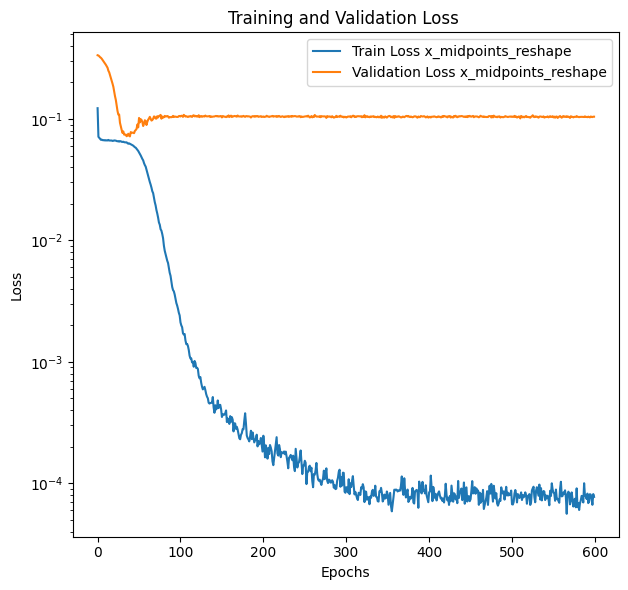

In [17]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
model_builder.model.save("/home/da886/Analysis/30KFixed_Mixed_5_32by32_95indexNoNoise.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, max_x, max_y, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - max_x: Maximum value for x-coordinate used during normalization.
    - max_y: Maximum value for y-coordinate used during normalization.
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Undo the normalization by multiplying by max_x and max_y
    true_midpoints_np[:, 0] *= max_x  # Rescale x-coordinate for GT
    true_midpoints_np[:, 1] *= max_y  # Rescale y-coordinate for GT
    pred_midpoints_np[:, 0] *= max_x  # Rescale x-coordinate for predictions
    pred_midpoints_np[:, 1] *= max_y  # Rescale y-coordinate for predictions

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_centers))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


2024-10-24 18:52:23.401770: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1729795943.684073 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.685316 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.685656 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.685976 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.686280 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.686574 1671813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795943.686906 1671813 gpu_timer

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   

W0000 00:00:1729795944.102742 1671844 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.103141 1671850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.103493 1671844 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.103971 1671850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.104320 1671844 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.104776 1671850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.105121 1671844 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.106156 1671850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729795944.106537 1671844 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing b

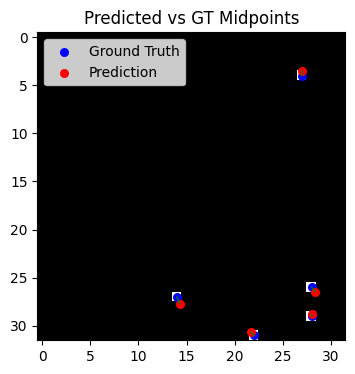

In [37]:

# Example: Select a random image and visualize it
index_to_visualize = np.random.randint(0, len(all_images))

# Retrieve max_x and max_y from your processor object (replace 'processor' with your actual instance)
max_x = processor.max_x
max_y = processor.max_y

# Visualize the results for the selected sample
visualize_midpoints_with_gt(
    all_images[index_to_visualize], 
    all_true_midpoints[index_to_visualize], 
    all_pred_midpoints[index_to_visualize], 
    max_x=max_x, 
    max_y=max_y
)


In [38]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((24000, 32, 32), (24000, 1, 5, 2), (24000, 1, 5, 2))

In [39]:
np.min(all_pred_midpoints),np.max(all_pred_midpoints)

(0.0019184444, 31.559818)

In [40]:
np.min(all_true_midpoints),np.max(all_true_midpoints)

(0.032258064, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[0.5761615 , 0.71336055],
         [0.8172825 , 0.9581117 ],
         [0.6705333 , 0.5542599 ],
         [0.9136867 , 0.12035519],
         [0.21837465, 0.6456019 ]]], dtype=float32),
 array([[[0.58064514, 0.7096774 ],
         [0.8064516 , 0.9677419 ],
         [0.67741936, 0.5483871 ],
         [0.9032258 , 0.12903225],
         [0.22580644, 0.6451613 ]]], dtype=float32))

In [42]:
centers

array([[[1.        , 0.67741936, 0.7419355 ],
        [1.        , 0.7419355 , 0.83870965],
        [1.        , 0.22580644, 0.19354838],
        [1.        , 0.3548387 , 0.9354839 ],
        [1.        , 0.3548387 , 0.9032258 ]],

       [[1.        , 0.22580644, 0.32258064],
        [1.        , 0.5483871 , 0.7096774 ],
        [1.        , 0.9032258 , 0.19354838],
        [1.        , 0.09677419, 0.22580644],
        [1.        , 0.83870965, 0.4516129 ]],

       [[1.        , 0.6451613 , 0.38709676],
        [1.        , 0.87096775, 0.16129032],
        [1.        , 0.32258064, 1.        ],
        [1.        , 0.32258064, 0.32258064],
        [1.        , 0.8064516 , 0.516129  ]],

       ...,

       [[1.        , 0.9032258 , 0.9354839 ],
        [1.        , 0.4516129 , 0.29032257],
        [1.        , 0.2580645 , 0.19354838],
        [1.        , 0.83870965, 0.58064514],
        [1.        , 0.09677419, 0.48387095]],

       [[1.        , 0.48387095, 0.2580645 ],
        [1.  

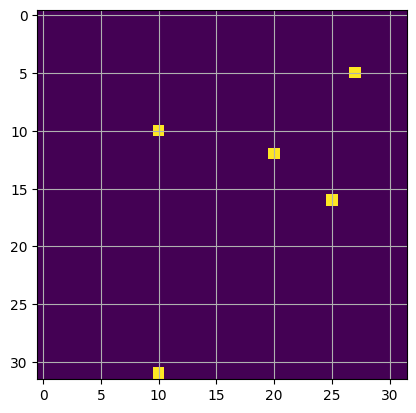

In [43]:
plt.imshow(images[2],)
plt.grid(True)

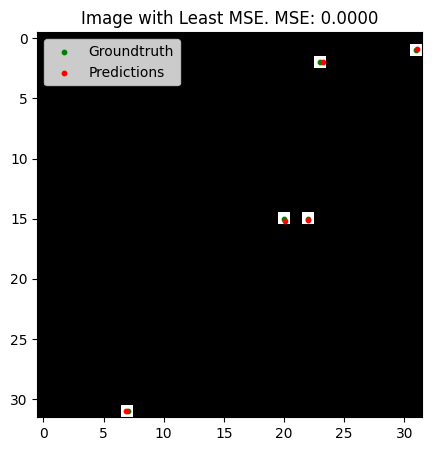

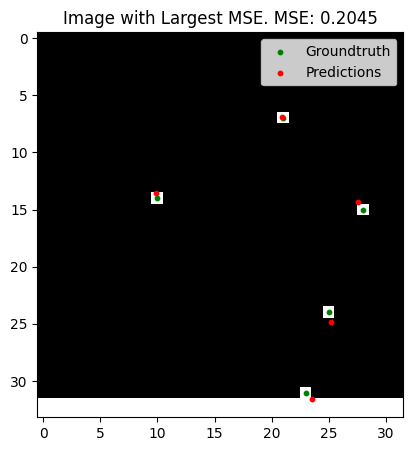

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0]*max_x ,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0]*max_y,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] ,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0],  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')


